In [1]:
# necessary libraries for prediciton
import utils
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Useful Functions

In [2]:
def pretty_matrix(matrix, row_label, col_label):
    """Pretty print of the given matrix """

    # Restraining labels that are too big
    row_label = [el[:10] + '..' if len(el) > 10 else el
                for el in row_label]
    col_label = [el[:10] + '..' if len(el) > 10 else el
                for el in col_label]

    # Stringfying everything & Joining top label
    s_matrix = [list([" "] + (col_label))] + \
               [[row_label[row_idx]] + \
                [str(e) for e in row] for row_idx, row in enumerate(matrix)]

    # Length of each matrix column
    len_s = [max(map(len, col)) for col in zip(*s_matrix)]

    # Cell formatation
    formatation = '\t'.join('{{:{}}}'.format(x) for x in len_s)

    # Apply cell formation to each matrix element
    pretty_mat = [formatation.format(*row) for row in s_matrix]

    # Print Pretty Matrix
    print('\n'.join(pretty_mat))


def display_confusion_matrix(values):
    '''Display the given array as a confusion matrix'''
    pretty_matrix([values[0:2], values[2:4]],
                  ['Actual NO', 'Actual YES'],
                  ['Predic NO', 'Predic YES'])

In [3]:
def plot_roc_auc(fpr, tpr, roc_auc):
    '''Plot the ROC-AUC curve'''
    fig, ax = plt.subplots()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'w--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([0, 1])
    ax.fill_between(fpr, 0, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
def normalize_columns(df, columns):
    '''Normalize the given columns for range between [0, 1]'''
    for col in columns:
        col_min = df[col].min()
        col_max =  df[col].max()
        
        df[col] = (df[col] - col_min)/\
                    (col_max - col_min)
        
def normalize_df(df):
    '''Normalize all columns of the given df'''
    normalize_columns(df, df.columns)

In [5]:
def apply_PCA(df, variance_val=0.9, debug=True):
    '''Apply the PCA algorithm to given dataframe,
    using the given variance val to trim the df'''
    # Necessary to normalize all data to use PCA
    scaler=StandardScaler()
    X_scaled=scaler.fit_transform(df)

    # PCA - keep, by default mode, 90% variance
    pca = PCA(variance_val)    
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)

    if debug:
        ex_variance=np.var(X_pca,axis=0)
        ex_variance_ratio = ex_variance/np.sum(ex_variance)
        print(' > Impact in total variance of each generated feature by PCA:')
        print(ex_variance_ratio)

    principal_df = pd.DataFrame(data = X_pca, index = df.reset_index()['loan_id'])
    
    return (principal_df, pca)

In [6]:
def auc_scorer(y_true, y_pred):
    '''Scorer of Area Under Curve value'''
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

# Prediction Algorithms

* Logistic Regression
* Decision Tree
* Random Forest
* Gradient Boosting

In [7]:
def create_LR():
    '''Create a Logistic Regression model'''
    return LogisticRegression()

In [8]:
def create_DT():
    '''Create a new Decision Tree'''
    # Useful DecisionTree tutorial:
    # https://www.datacamp.com/community/tutorials/decision-tree-classification-python
    return DecisionTreeClassifier()

In [9]:
def create_RF():
    '''Create a new Ranfom Forest model'''
    return RandomForestClassifier()

In [10]:
def create_GB():
    '''Create a new Gradient Boosting model'''
    return GradientBoostingClassifier()

# Prediction

* Predictions are done in this notebook.
* It is also useful to compare how serveral algorithms perform against one another.

In [11]:
pd.set_option('display.max_columns', 200)

# Useful Macros
K_FOLD_NUM_SPLITS = 5
SEED = 42
USE_PCA = False
UNDERSAMPLE = False
UNDERSAMPLE_RATIO = 0.3

# Pretty printer
pp = pprint.PrettyPrinter(indent=4)

In [12]:
dataset =  utils.read_csv_to_df('dataset/preprocessed_data.csv')

if UNDERSAMPLE:
    print(' > Apllying undersampling:')
    entries_df = len(dataset.index)

    # Getting all minor class cases into final dataset
    minor_df = dataset[dataset['status'] == -1]
    num_minor = len(minor_df.index)
    
    print('\t> Classes initial ratio: %f - %f\n\t> Dataset size: %i' %
         (num_minor / entries_df, (entries_df - num_minor) / entries_df, entries_df))

    # Selecting equal number from major class
    major_df = dataset[dataset['status'] == 1].sample(n=int((num_minor / UNDERSAMPLE_RATIO) - num_minor),
                                                      random_state=SEED)
    num_major = len(major_df.index)
    total_under = num_minor + num_major
    
    print('\t> Classes final ratio: %f - %f\n\t> Dataset size: %i' % 
          (num_minor / total_under, num_major / total_under, total_under))

    # Concatenting to main dataframe
    dataset = pd.concat([minor_df, major_df])

dataset = dataset.set_index('loan_id')
display(dataset)

# Normalizing dataset
print(' > Dataset after normalization')
normalize_df(dataset)
display(dataset)

,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,credit_mean,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_min,withdrawal_max,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,ratio entrepeneurs,criminalty_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,trans_per_day,income_to_payments_ratio,status
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5314,741830400000000000,96396,8033,2,12250.000000,20100.0,1100.0,8330.866301,20100.0,3300.0,5025.000000,9900.0,1100.0,3774.806838,0.000000,0.0,0.0,0.000000,5025.000000,20100.0,4,3774.806838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5025.000000,1.000000,0.000000,19000.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1,1,-1.0,7,94812,15,13,8,2,10,0.818,0.100,-0.001909,0.29,105,15,45.986301,0.208515,0.038095,1.201295,-1
5316,742348800000000000,165960,4610,1,52083.859459,120512.8,700.0,29122.059454,52208.9,-3419.0,13523.158824,36574.0,2.9,13998.092225,-8884.240000,-14.6,-54300.0,14074.800608,2608.833333,62612.0,24,22249.103350,-14.6,-43.8,3.0,-956.0,-2868.0,3.0,0.0,0.0,0.0,0.0,4638.918824,0.459459,0.540541,119812.8,0.324324,0.000000,0.324324,0.216216,0.0,0.135135,1,0,-1.0,2,112709,48,20,7,3,10,0.735,0.117,-0.002094,0.52,148,2,24.986301,0.726156,0.250000,1.890727,1
6863,743817600000000000,127080,2118,1,30060.954167,49590.4,800.0,11520.184451,20272.8,-12000.0,5009.733333,19065.0,48.6,6801.234716,-6097.000000,-66.0,-14800.0,5390.565972,1966.714286,27534.0,14,10647.755108,0.0,0.0,0.0,-66.0,-66.0,1.0,0.0,0.0,0.0,0.0,-1087.266667,0.625000,0.375000,48790.4,0.083333,0.208333,0.250000,0.125000,0.0,0.333333,1,0,-1.0,2,77917,85,19,6,1,5,0.535,0.132,0.000539,0.61,170,7,57.191781,0.390230,0.141176,4.273528,1
5325,744336000000000000,105804,2939,1,41297.480000,65898.5,1000.0,14151.260443,34307.3,178.1,9254.600000,26448.0,132.8,9818.591218,-7168.100000,-14.6,-15600.0,4919.096434,2969.250000,47508.0,16,13937.959427,-14.6,-29.2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2086.500000,0.520000,0.480000,64898.5,0.080000,0.240000,0.400000,0.080000,0.0,0.200000,1,1,-1.0,5,177686,69,27,10,1,9,0.748,0.135,-0.001739,0.29,185,3,53.323288,0.622836,0.135135,3.616139,1
7240,747273600000000000,274740,4579,2,57188.211111,122893.1,600.0,25256.665817,41112.9,-30.0,21255.930769,63366.0,77.1,24264.229780,-16801.000000,-30.0,-36700.0,13981.924936,2266.000000,40788.0,18,33727.841554,-30.0,-60.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4454.930769,0.481481,0.518519,122293.1,0.037037,0.222222,0.407407,0.111111,0.0,0.222222,1,0,-1.0,6,86513,38,36,5,1,5,0.505,0.110,-0.001179,0.73,204,6,15.008219,0.447307,0.132353,1.823761,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6818,850348800000000000,155616,3242,1,44197.509884,75294.1,200.0,11044.494392,60694.1,-14600.0,6448.582857,26388.0,23.7,9143.297044,-3830.458824,-14.6,-36960.0,5002.156631,1099.152174,101122.0,92,11706.297462,-14.6,-262.8,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2618.124034,0.406977,0.593023,75094.1,0.151163,0.000000,0.383721,0.209302,0.0,0.255814,2,1,-1.0,4,226122,32,50,7,4,4,0.626,0.110,-0.002052,0.99,691,1,25.693151,0.48384

 > Dataset after normalization


,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,credit_mean,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_min,withdrawal_max,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,ratio entrepeneurs,criminalty_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,trans_per_day,income_to_payments_ratio,status
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5314,0.000000,0.171345,0.823266,1.0,0.000000,0.000000,0.273848,0.097263,0.128125,0.517311,0.100131,0.025633,1.000000,0.049126,1.000000,1.000000,1.000000,0.000000,0.565940,0.094611,0.000000,0.014891,1.000,1.0000,0.000000,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,0.624874,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,1.000000,0.044738,0.099338,0.185714,0.40,0.4,0.9,0.724660,0.220930,0.727478,0.143014,0.000000,0.666667,0.685425,0.012673,0.002641,0.009509,0.0
5316,0.004721,0.301732,0.457951,0.5,0.622572,0.577716,0.249638,0.792831,0.377597,0.447516,0.449603,0.427822,0.001910,0.452368,0.700270,0.999274,0.163328,0.689218,0.297839,0.250351,0.148148,0.496622,0.854,0.9781,0.136364,0.895118,0.980702,0.157895,1.0,1.0,0.0,0.0,0.610923,0.286947,0.713053,0.578022,0.319696,0.000000,0.496415,0.578378,0.0,0.270270,0.0,0.0,0.0,0.285714,0.060138,0.317881,0.285714,0.35,0.6,0.9,0.599092,0.418605,0.723619,0.193619,0.072758,0.047619,0.241205,0.067419,0.718487,0.033752,1.0
6863,0.018096,0.228857,0.191996,0.5,0.278371,0.169670,0.255691,0.203961,0.129468,0.358378,0.099503,0.163822,0.043486,0.168499,0.794304,0.996716,0.771957,0.263967,0.226589,0.121845,0.074074,0.194108,1.000,1.0000,0.000000,0.992759,0.999556,0.052632,1.0,1.0,0.0,0.0,0.404010,0.505319,0.494681,0.170807,0.077055,0.572917,0.382653,0.334375,0.0,0.666667,0.0,0.0,0.0,0.285714,0.030200,0.562914,0.271429,0.30,0.2,0.4,0.296520,0.593023,0.778583,0.213421,0.109983,0.285714,0.922457,0.031892,0.350865,0.117538,1.0
5325,0.022817,0.188979,0.279616,0.5,0.453990,0.263498,0.267796,0.291984,0.238510,0.484882,0.274066,0.275142,0.120087,0.287514,0.758168,0.999274,0.759630,0.240880,0.337832,0.195018,0.088889,0.279903,0.854,0.9854,0.090909,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,0.518693,0.366809,0.633191,0.263165,0.073699,0.660000,0.612245,0.214000,0.0,0.400000,0.0,1.0,0.0,0.714286,0.116050,0.456954,0.385714,0.50,0.2,0.8,0.618759,0.627907,0.731027,0.143014,0.135364,0.095238,0.840626,0.056492,0.330457,0.094422,1.0
7240,0.049567,0.505623,0.454642,1.0,0.702349,0.591411,0.243586,0.663515,0.291386,0.482720,0.767600,0.831790,0.069414,0.857301,0.433181,0.998507,0.434515,0.684670,0.259798,0.170400,0.103704,0.795939,0.700,0.9700,0.090909,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,0.604275,0.315997,0.684003,0.592243,0.030441,0.611111,0.623583,0.297222,0.0,0.444444,0.0,0.0,0.0,0.857143,0.037596,0.251656,0.514286,0.25,0.2,0.4,0.251135,0.337209,0.742718,0.239824,0.167513,0.238095,0.030136,0.037928,0.321058,0.031397,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6818,0.988198,0.282344,0.311953,0.5,0.499315,0.317554,0.219376,0.188047,0.443523,0.331370,0.158673,0.274

In [13]:
STATUS_COL = dataset.columns.get_loc("status")

In [14]:
# Setting X and Y
X = dataset.iloc[:, 0:STATUS_COL]
y = dataset.iloc[:, [STATUS_COL]]
display(X.head())

if USE_PCA:
    print(' > Applying PCA to X_train:')
    X, pca = apply_PCA(X, debug=True)
    display(X.head())

,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,credit_mean,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_min,withdrawal_max,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,ratio entrepeneurs,criminalty_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,trans_per_day,income_to_payments_ratio
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5314,0.000000,0.171345,0.823266,1.0,0.000000,0.000000,0.273848,0.097263,0.128125,0.517311,0.100131,0.025633,1.000000,0.049126,1.000000,1.000000,1.000000,0.000000,0.565940,0.094611,0.000000,0.014891,1.000,1.0000,0.000000,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,0.624874,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,1.000000,0.044738,0.099338,0.185714,0.40,0.4,0.9,0.724660,0.220930,0.727478,0.143014,0.000000,0.666667,0.685425,0.012673,0.002641,0.009509
5316,0.004721,0.301732,0.457951,0.5,0.622572,0.577716,0.249638,0.792831,0.377597,0.447516,0.449603,0.427822,0.001910,0.452368,0.700270,0.999274,0.163328,0.689218,0.297839,0.250351,0.148148,0.496622,0.854,0.9781,0.136364,0.895118,0.980702,0.157895,1.0,1.0,0.0,0.0,0.610923,0.286947,0.713053,0.578022,0.319696,0.000000,0.496415,0.578378,0.0,0.270270,0.0,0.0,0.0,0.285714,0.060138,0.317881,0.285714,0.35,0.6,0.9,0.599092,0.418605,0.723619,0.193619,0.072758,0.047619,0.241205,0.067419,0.718487,0.033752
6863,0.018096,0.228857,0.191996,0.5,0.278371,0.169670,0.255691,0.203961,0.129468,0.358378,0.099503,0.163822,0.043486,0.168499,0.794304,0.996716,0.771957,0.263967,0.226589,0.121845,0.074074,0.194108,1.000,1.0000,0.000000,0.992759,0.999556,0.052632,1.0,1.0,0.0,0.0,0.404010,0.505319,0.494681,0.170807,0.077055,0.572917,0.382653,0.334375,0.0,0.666667,0.0,0.0,0.0,0.285714,0.030200,0.562914,0.271429,0.30,0.2,0.4,0.296520,0.593023,0.778583,0.213421,0.109983,0.285714,0.922457,0.031892,0.350865,0.117538
5325,0.022817,0.188979,0.279616,0.5,0.453990,0.263498,0.267796,0.291984,0.238510,0.484882,0.274066,0.275142,0.120087,0.287514,0.758168,0.999274,0.759630,0.240880,0.337832,0.195018,0.088889,0.279903,0.854,0.9854,0.090909,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,0.518693,0.366809,0.633191,0.263165,0.073699,0.660000,0.612245,0.214000,0.0,0.400000,0.0,1.0,0.0,0.714286,0.116050,0.456954,0.385714,0.50,0.2,0.8,0.618759,0.627907,0.731027,0.143014,0.135364,0.095238,0.840626,0.056492,0.330457,0.094422
7240,0.049567,0.505623,0.454642,1.0,0.702349,0.591411,0.243586,0.663515,0.291386,0.482720,0.767600,0.831790,0.069414,0.857301,0.433181,0.998507,0.434515,0.684670,0.259798,0.170400,0.103704,0.795939,0.700,0.9700,0.090909,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,0.604275,0.315997,0.684003,0.592243,0.030441,0.611111,0.623583,0.297222,0.0,0.444444,0.0,0.0,0.0,0.857143,0.037596,0.251656,0.514286,0.25,0.2,0.4,0.251135,0.337209,0.742718,0.239824,0.167513,0.238095,0.030136,0.037928,0.321058,0.031397


# Hyper Parameter Tunning

## Random Search 1st to apporach the best solution, GridSearch to refine it

In [15]:
def getLogisticRegressionBest(X, y, debug=True):
    '''Get the Logistic Regression Hyper Parameters'''

    # Maximum number of levels in tree
    max_depth = [int(x) for x in range(2, 20, 4)]
    max_depth.append(None)

    # Create the random grid
    grid = {'penalty': ['l2', 'none'],
            'C': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
            'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'class_weight': ["balanced", None]}
    
    if debug:
        pp.pprint(grid)
    
    # Using the grid search for best hyperparameters
    lr = create_LR()
    lr_grid = GridSearchCV(estimator = lr,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    lr_grid = lr_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', lr_grid.best_score_)
        print('Best Params: ', lr_grid.best_params_)
        
    # Return score, method & params tuple
    return (lr_grid.best_score_, 'Logistic Regression', lr_grid.best_params_)

In [16]:
def getDecisionTreeBest(X, y, debug=True):
    '''Get the Decision Tree Hyper Parameters'''

    # Maximum number of levels in tree
    max_depth = [int(x) for x in range(2, 20, 4)]
    max_depth.append(None)

    # Create the random grid
    grid = {'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_features': ['auto', 'sqrt'],
            'max_depth': max_depth,
            'min_samples_split':  [2, 5, 10],
            'min_samples_leaf':  [1, 2, 4],
            'class_weight': ["balanced", None]}
    
    if debug:
        pp.pprint(grid)
    
    # Using the grid search for best hyperparameters
    dt = create_DT()
    dt_grid = GridSearchCV(estimator = dt,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    dt_grid = dt_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', dt_grid.best_score_)
        print('Best Params: ', dt_grid.best_params_)
        
    # Return score, method & params tuple
    return (dt_grid.best_score_, 'Decision Tree', dt_grid.best_params_)

In [17]:
def getRandomForestBest(X, y, debug=True):
    '''Get the Random Forest Hyper Parameters'''

    # Maximum number of levels in tree
    max_depth = [int(x) for x in range(2, 16, 4)]
    max_depth.append(None)

    # Create the random grid
    grid = {'n_estimators': [int(x) for x in range(2, 14, 2)],
            'max_features': ['auto', 'sqrt'],
            'max_depth': max_depth,
            'criterion': ['gini', 'entropy'],
            'min_samples_split':  [2, 5, 10],
            'min_samples_leaf':  [1, 2, 4],
            'bootstrap': [True, False],
            'class_weight': ["balanced", "balanced_subsample", None]}
    
    if debug:
        pp.pprint(grid)
    
    # Using the grid search for best hyperparameters
    rf = create_RF()
    rf_grid = GridSearchCV(estimator = rf,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    rf_grid = rf_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', rf_grid.best_score_)
        print('Best Params: ', rf_grid.best_params_)
        
    # Return score, method & params tuple
    return (rf_grid.best_score_, 'Random Forest', rf_grid.best_params_)

In [18]:
def getGradientBoostBest(X, y, debug=True):
    '''Get the Gradient Boost Hyper Parameters'''

    # Create the grid parameters
    grid = {'n_estimators': [int(x) for x in range(2, 14, 2)],
            'learning_rate': [0.1, 0.3, 0.5, 0.7],
            'loss': ['deviance', 'exponential'],
            'criterion': ['friedman_mse', 'mse', 'mae'],
            'min_samples_split':  [2, 5, 10],
            'min_samples_leaf':  [1, 2, 4],
            'random_state': [SEED]}
    
    if debug:
        pp.pprint(grid)
    
    # Using the grid search for best hyperparameters
    gb = create_GB()
    gb_grid = GridSearchCV(estimator = gb,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    gb_grid = gb_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', gb_grid.best_score_)
        print('Best Params: ', gb_grid.best_params_)
        
    # Return score, method & params tuple
    return (gb_grid.best_score_, 'Gradient Boosting', gb_grid.best_params_)

In [19]:
# Getting the best algorithm
algorithms = [getLogisticRegressionBest(X, y),
              getDecisionTreeBest(X, y),
              getRandomForestBest(X, y),
              getGradientBoostBest(X, y)]
algorithms.sort(reverse=True, key=lambda el: el[0])

for index, entry in enumerate(algorithms):
    print('%i. %s - %f\n---------' % (index + 1, entry[1], entry[0]))
    
print('Best algorithm: %s' % algorithms[0][1])

{   'C': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'class_weight': ['balanced', None],
    'penalty': ['l2', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   15.3s finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-package

Best Score:  0.7209667970739859
Best Params:  {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
{   'class_weight': ['balanced', None],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 6, 10, 14, 18, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'splitter': ['best', 'random']}
Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done 598 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:   10.0s finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.7715569411333211
Best Params:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'best'}
{   'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 6, 10, 14, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 4196 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 7592 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 11972 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 17312 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 23636 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 30920 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 32400 out of 32400 | elapsed:  5.4min finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/edgarcarneiro/Documents/University/feup-ecac/pro

Best Score:  0.8388655518369093
Best Params:  {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 8}
{   'criterion': ['friedman_mse', 'mse', 'mae'],
    'learning_rate': [0.1, 0.3, 0.5, 0.7],
    'loss': ['deviance', 'exponential'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [2, 4, 6, 8, 10, 12],
    'random_state': [42]}
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2344 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 4658 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5224 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5954 tasks      | elapsed:  2.4min


Best Score:  0.7346459390345783
Best Params:  {'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'deviance', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 12, 'random_state': 42}
1. Random Forest - 0.838866
---------
2. Decision Tree - 0.771557
---------
3. Gradient Boosting - 0.734646
---------
4. Logistic Regression - 0.720967
---------
Best algorithm: Random Forest


[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  3.0min finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Using method with higher score with our data

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


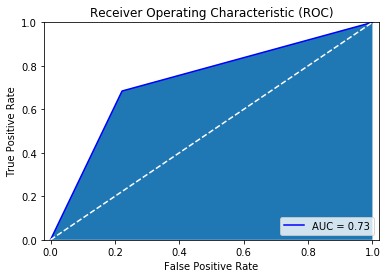

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


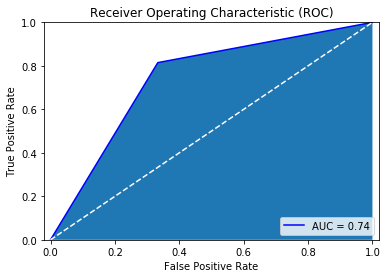

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


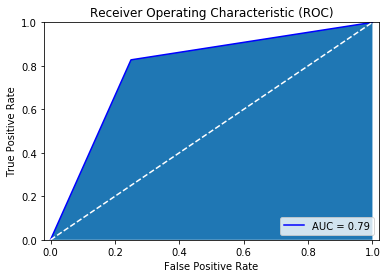

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


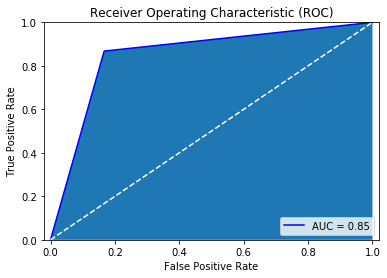

/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


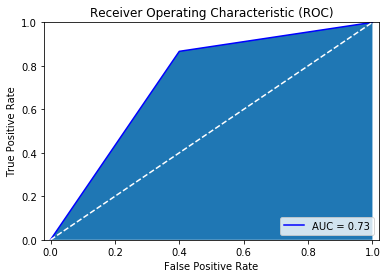

In [26]:
# Cross validation settings
auc_scores = []
confusion_matrixes = []
cv = KFold(n_splits=K_FOLD_NUM_SPLITS, random_state=SEED, shuffle=False)

# CHANGE THIS LINE TO CHANGE THE USED CLASSIFICATION METHOD
# classifier = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, min_samples_split=10, splitter='best')
# classifier = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.7, loss='deviance',
#                                         min_samples_leaf=2, min_samples_split=2, n_estimators=8, random_state=SEED)
classifier = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='entropy',
                                    max_depth=2, max_features='auto', min_samples_leaf=4,
                                    min_samples_split=2, n_estimators=8)


# Applying Cross validation
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training with this fold
    classifier.fit(X_train, y_train)
    
    # Testing & Measuring accuracy
    y_pred = classifier.predict(X_test)
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)

    auc_scores.append(auc)
    confusion_matrixes.append(metrics.confusion_matrix(y_test, y_pred).ravel())

    plot_roc_auc(fpr, tpr, auc)

In [27]:
# Printing the obtained results
print('Classification Method used:', classifier, '\n')
print('AUC scores:', auc_scores)
print('> Average: ', sum(auc_scores)/len(auc_scores))
for cf in confusion_matrixes:
    display_confusion_matrix(cf)

Classification Method used: RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=8, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False) 

AUC scores: [0.7309941520467835, 0.7407407407407409, 0.7887931034482758, 0.85062893081761, 0.7333333333333333]
> Average:  0.7688980520773487
          	Predic NO	Predic YES
Actual NO 	7        	2         
Actual YES	18       	39        
          	Predic NO	Predic YES
Actual NO 	8        	4         
Actual YES	10       	44        
          	Predic NO	Predic YES
Actual NO 	6        	2         
Actual YES	10       	48        
          	Predic NO	Predic YES
Actual NO 	1

### After having our model trained we shall use the model on the data to be sumitted in the kaggle

In [22]:
test_dataset =  utils.read_csv_to_df('dataset/test_dataset.csv')
test_dataset = test_dataset.set_index('loan_id')
normalize_df(test_dataset)
display(test_dataset.head())

,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,credit_mean,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_min,withdrawal_max,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,ratio entrepeneurs,criminalty_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,trans_per_day,income_to_payments_ratio,status
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5895,0.000000,0.151641,0.131376,0.5,0.663113,0.479278,0.474157,0.300447,0.456208,0.374456,0.422053,0.441291,0.136424,0.420737,0.811984,0.999327,0.619772,0.334722,0.141099,0.360467,0.400000,0.324138,0.854,0.930476,0.476190,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.660156,0.146538,0.853462,0.477465,0.175218,0.000000,0.664794,0.546415,0.0,0.334270,0.0,0.0,0.0,0.285714,0.030200,0.562914,0.271429,0.30,0.2,0.4,0.296520,0.593023,0.778583,0.213421,0.588235,0.04,0.389496,0.071021,0.496522,0.152181,NaN
7122,0.001420,0.436237,0.722049,0.5,0.352906,0.482253,0.433774,0.521972,0.117237,0.645419,0.292655,0.518229,0.025183,0.434309,0.820324,0.999788,0.619772,0.360368,0.073646,0.147094,0.303704,0.341939,0.854,0.951333,0.333333,0.959893,0.983227,0.285714,0.870568,0.987057,0.1,0.0,0.572825,0.191233,0.808767,0.489739,0.174929,0.000000,0.493056,0.754731,0.0,0.408654,0.0,1.0,0.0,1.000000,0.013406,0.430464,0.228571,0.20,0.2,0.5,0.279879,0.220930,0.777339,0.112211,0.652101,0.08,0.688919,0.024341,0.390888,0.011519,NaN
6173,0.007102,0.388292,0.472725,0.0,0.469661,0.424325,0.458202,0.361902,0.422345,0.518545,0.523149,0.543721,0.075550,0.503364,0.846893,0.995392,0.631179,0.322285,0.070864,0.341665,0.792593,0.328285,0.000,0.238095,0.761905,0.965952,0.964402,0.714286,1.000000,1.000000,0.0,0.0,0.764744,0.027116,0.972884,0.426255,0.011585,0.312500,0.605114,0.887108,0.0,0.241477,0.0,1.0,0.0,0.714286,0.116050,0.456954,0.385714,0.50,0.2,0.8,0.618759,0.627907,0.731027,0.143014,0.887395,0.00,0.907412,0.024379,0.727461,0.039553,NaN
6142,0.025568,0.370057,0.353321,0.5,0.527183,0.393232,0.479476,0.303198,0.361298,0.517020,0.383280,0.391932,0.089726,0.373754,0.861084,0.999908,0.731305,0.292314,0.077756,0.161846,0.318519,0.267404,0.854,0.965238,0.238095,0.958197,0.982518,0.285714,1.000000,1.000000,0.0,0.0,0.674889,0.093363,0.906637,0.390300,0.022770,0.387324,0.541667,0.865191,0.0,0.269366,1.0,1.0,0.0,0.142857,0.033149,0.403974,0.328571,0.20,0.4,0.5,0.323752,0.790698,0.639015,0.206821,0.351261,0.28,0.809056,0.023877,0.584439,0.048932,NaN
5358,0.025568,0.056981,0.302519,0.5,0.200691,0.130033,0.476817,0.000000,0.182821,0.514961,0.021654,0.032048,0.032355,0.009590,0.931186,0.999327,0.931559,0.075004,0.082061,0.237976,0.459259,0.014945,0.854,0.895714,0.714286,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.471897,0.299821,0.700179,0.128036,0.285526,0.000000,0.596857,0.359231,0.0,0.354167,0.0,0.0,0.0,0.285714,0.045680,0.576159,0.357143,0.25,0.4,0.6,0.381241,0.069767,0.769507,0.195820,0.831933,0.24,0.894527,0.061153,0.479864,0.057868,NaN


In [23]:
# We now remove the Y column with NaNs
test_dataset = test_dataset.iloc[:, 0:STATUS_COL]

display(test_dataset.head())

,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,credit_mean,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_min,withdrawal_max,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,ratio entrepeneurs,criminalty_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,trans_per_day,income_to_payments_ratio
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5895,0.000000,0.151641,0.131376,0.5,0.663113,0.479278,0.474157,0.300447,0.456208,0.374456,0.422053,0.441291,0.136424,0.420737,0.811984,0.999327,0.619772,0.334722,0.141099,0.360467,0.400000,0.324138,0.854,0.930476,0.476190,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.660156,0.146538,0.853462,0.477465,0.175218,0.000000,0.664794,0.546415,0.0,0.334270,0.0,0.0,0.0,0.285714,0.030200,0.562914,0.271429,0.30,0.2,0.4,0.296520,0.593023,0.778583,0.213421,0.588235,0.04,0.389496,0.071021,0.496522,0.152181
7122,0.001420,0.436237,0.722049,0.5,0.352906,0.482253,0.433774,0.521972,0.117237,0.645419,0.292655,0.518229,0.025183,0.434309,0.820324,0.999788,0.619772,0.360368,0.073646,0.147094,0.303704,0.341939,0.854,0.951333,0.333333,0.959893,0.983227,0.285714,0.870568,0.987057,0.1,0.0,0.572825,0.191233,0.808767,0.489739,0.174929,0.000000,0.493056,0.754731,0.0,0.408654,0.0,1.0,0.0,1.000000,0.013406,0.430464,0.228571,0.20,0.2,0.5,0.279879,0.220930,0.777339,0.112211,0.652101,0.08,0.688919,0.024341,0.390888,0.011519
6173,0.007102,0.388292,0.472725,0.0,0.469661,0.424325,0.458202,0.361902,0.422345,0.518545,0.523149,0.543721,0.075550,0.503364,0.846893,0.995392,0.631179,0.322285,0.070864,0.341665,0.792593,0.328285,0.000,0.238095,0.761905,0.965952,0.964402,0.714286,1.000000,1.000000,0.0,0.0,0.764744,0.027116,0.972884,0.426255,0.011585,0.312500,0.605114,0.887108,0.0,0.241477,0.0,1.0,0.0,0.714286,0.116050,0.456954,0.385714,0.50,0.2,0.8,0.618759,0.627907,0.731027,0.143014,0.887395,0.00,0.907412,0.024379,0.727461,0.039553
6142,0.025568,0.370057,0.353321,0.5,0.527183,0.393232,0.479476,0.303198,0.361298,0.517020,0.383280,0.391932,0.089726,0.373754,0.861084,0.999908,0.731305,0.292314,0.077756,0.161846,0.318519,0.267404,0.854,0.965238,0.238095,0.958197,0.982518,0.285714,1.000000,1.000000,0.0,0.0,0.674889,0.093363,0.906637,0.390300,0.022770,0.387324,0.541667,0.865191,0.0,0.269366,1.0,1.0,0.0,0.142857,0.033149,0.403974,0.328571,0.20,0.4,0.5,0.323752,0.790698,0.639015,0.206821,0.351261,0.28,0.809056,0.023877,0.584439,0.048932
5358,0.025568,0.056981,0.302519,0.5,0.200691,0.130033,0.476817,0.000000,0.182821,0.514961,0.021654,0.032048,0.032355,0.009590,0.931186,0.999327,0.931559,0.075004,0.082061,0.237976,0.459259,0.014945,0.854,0.895714,0.714286,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.471897,0.299821,0.700179,0.128036,0.285526,0.000000,0.596857,0.359231,0.0,0.354167,0.0,0.0,0.0,0.285714,0.045680,0.576159,0.357143,0.25,0.4,0.6,0.381241,0.069767,0.769507,0.195820,0.831933,0.24,0.894527,0.061153,0.479864,0.057868


In [24]:
final_df = pd.DataFrame()

if USE_PCA:
    # Using train PCA and classifying
    scaler=StandardScaler()
    X_test_scaled=scaler.fit_transform(test_dataset)
    predictions_df = pd.DataFrame(data = pca.transform(X_test_scaled),
                                  index=test_dataset.reset_index()['loan_id'])
    display(predictions_df)

    predictions_df['Predicted'] = classifier.predict(predictions_df)
    final_df = predictions_df.reset_index()\
                    [['loan_id', 'Predicted']]\
                    .rename(columns={
                        'loan_id': 'Id'
                    })
    
else:
    final_df = test_dataset.copy()
    final_df['Predicted'] = classifier.predict(final_df)
    final_df = final_df.reset_index()\
                        [['loan_id', 'Predicted']]\
                        .rename(columns={
                            'loan_id': 'Id'
                        })\
                        .drop_duplicates()

display(final_df)

,Id,Predicted
0,5895,1.0
1,7122,0.0
2,6173,1.0
3,6142,1.0
4,5358,1.0
...,...,...
349,4989,0.0
350,5221,0.0
351,6402,1.0
352,5346,1.0


In [25]:
# Outputting predictions to .csv
# CHANGE FILE NAME TO PRESERVE DIFFERENT INSTANCES
utils.write_df_to_csv(final_df, 'predictions', 'prediction.csv')